# TCP transport in coarse sand aquifer with Freundlich sorption

In [2]:
import sys
import os
import numpy as np
import matplotlib as mpl
import pickle as pk
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf
import shutil
import time
%matplotlib inline
from IPython.display import clear_output
from time import sleep

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy
    
from flopy.utils.util_array import read1d

mpl.rcParams['figure.figsize'] = (8, 8)

exe_name_mf = '/Users/zitongzhou/Downloads/pymake/examples/mf2005'
exe_name_mt = '/Users/zitongzhou/Downloads/pymake/examples/mt3dms'
datadir = os.path.join('..', 'mt3d_test', 'mt3dms')
workdir = os.path.join('.',)
    
print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

flopy is installed in /Applications/anaconda3/envs/fipy/lib/python3.7/site-packages/flopy
3.7.5 (default, Oct 25 2019, 10:52:18) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version: 1.18.1
matplotlib version: 3.1.3
flopy version: 3.3.0


## 2d MODFLOW model
head gradient $\nabla h$= 0.0012, 

hydraulic conductivity K_mean = 33.528 m/day, K ~ gaussian, var=1, len_scale=[5.0, 15.0]


In [3]:
## observation points
np.random.seed(888)
y_obs = np.random.randint(low = 5, high = 35, size = 20)
x_obs = np.random.randint(low = 30, high = 80, size = 20)
obs = [[0, y_obs[i], x_obs[i]] for i in range(len(y_obs))]

In [4]:
obs

[[0, 31, 49],
 [0, 18, 56],
 [0, 20, 48],
 [0, 27, 76],
 [0, 24, 60],
 [0, 12, 31],
 [0, 19, 69],
 [0, 30, 32],
 [0, 33, 38],
 [0, 18, 65],
 [0, 22, 74],
 [0, 21, 38],
 [0, 34, 55],
 [0, 17, 44],
 [0, 5, 66],
 [0, 30, 59],
 [0, 8, 52],
 [0, 21, 60],
 [0, 11, 40],
 [0, 31, 40]]

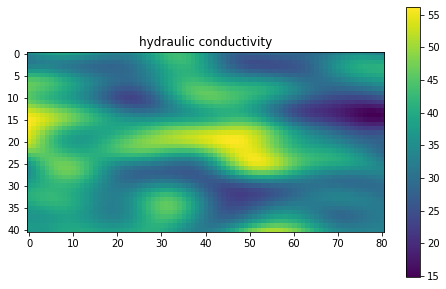

In [2]:
import gstools as gs
import matplotlib.pyplot as plt
x = range(41)
y = range(81)
np.random.seed(888)
model = gs.Gaussian(dim=2, var=70, len_scale=[4.5, 12.0])
srf = gs.SRF(model, mean = 33.528, seed=888)
out = srf((x, y), mesh_type='structured')

fig, axs = plt.subplots(1,1)
c01map = axs.imshow(out, interpolation='none')
fig.colorbar(c01map, ax=axs,shrink=0.62)
title = 'hydraulic conductivity'
name = title + '.pdf'
plt.title(title)
fig.savefig(name, format='pdf',bbox_inches='tight')

with open('hk','wb') as file:
     pk.dump(out, file)

In [3]:
with open('hk', 'rb') as file:
    hk = pk.load(file)

In [4]:
def simple_plot(c_map, title):
    nx = 81
    ny = 41
    Lx = 2500
    Ly = 1250

    x = np.linspace(0, Lx, nx)
    y = np.linspace(0, Ly, ny)
    X,Y = np.meshgrid(x, y)
    fig, axs = plt.subplots(1,1)
#        axs.set_xlabel('x(m)')
#        axs.set_ylabel('y(m)')
    axs.set_xlim(0,Lx)
    axs.set_ylim(0,Ly)
    c01map = axs.imshow(c_map, cmap='jet',
              extent=[x.min(), x.max(), y.min(), y.max()],
              vmin=c_map.min(), vmax = c_map.max(),
              origin='lower')
#        CS = axs.contour(head, levels = np.arange(0, 10.5, 0.5), origin='lower', cmap='flag',
#                linewidths=2, extent=[x.min(), x.max(), y.min(), y.max()],)
#        fig.colorbar(c01map, ax=axs,shrink=0.62)
    name = title + '.pdf'
    plt.title(title)
    fig.savefig('images/'+name, format='pdf',bbox_inches='tight')
    plt.show()
    return

In [43]:
from scipy.io import loadmat
annots = loadmat("/Volumes/GoogleDrive/My Drive/inverse_modeling/reactive_transport/kd.mat")
annots.keys()

kle = annots['kle_terms']
K = annots['K']

In [295]:
def run_model(dirname, hk, welspd, c_spd):
    if os.path.isdir(dirname):
        shutil.rmtree(dirname, ignore_errors=True)
        
#     with open('hk', 'rb') as file:
#         hk = pk.load(file)
        
    mixelm = -1 # algorithm
    
    model_ws = os.path.join(workdir, dirname)
    Lx = 2500.
    Ly = 1250.
    ztop = 0.
    zbot = -50.
    nlay = 1
    nrow = 41
    ncol = 81
    delr = Lx / (ncol-1)  # spacings along a row, can be an array
    delc = Ly / (nrow-1)  # spacings along a column, can be an array
#        delv = (ztop - zbot) / nlay
    delv = 50
    prsity = 0.3
    
    q0 = 100.
    c0 = 10000.
    
    perlen_mf = [365*2]*10 + [365/2]*40
    perlen_mt = [365*2]*10 + [365/2]*40
#     nper = len(perlen_mf)
    laytyp = 0. 
    rhob = 1.587 #bulk density of porous media
    
    modelname_mf = dirname + '_mf'
    mf = flopy.modflow.Modflow(modelname=modelname_mf, model_ws=model_ws, exe_name=exe_name_mf)
    dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol,
                                   delr=delr, delc=delc, top=ztop, botm=[0 - delv],nper=len(perlen_mf),
                                   perlen=perlen_mf)
    # Variables for the BAS package
    # active > 0, inactive = 0, or constant head < 0
    ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
    ibound[:, :, 0] = -1
    ibound[:, :, -1] = -1

    # initial head value also serves as boundary conditions
    strt = np.ones((nlay, nrow, ncol), dtype=np.float32)
    h_grad = 0.0012
    l_head, r_head = h_grad*Lx, 0.
    strt[:, :, 0] = l_head
    strt[:, :, -1] = r_head
    
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    lpf = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=laytyp)
    pcg = flopy.modflow.ModflowPcg(mf)
    lmt = flopy.modflow.ModflowLmt(mf, output_file_name='mt3d_link.ftl')

    wel = flopy.modflow.ModflowWel(mf, stress_period_data=welspd)
    
#     spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}
    spd = {(0, 0): ['save head', 'save budget']}
#     oc = flopy.modflow.ModflowOc(mf, stress_period_data=spd, compact=True)
    oc = flopy.modflow.ModflowOc(mf,compact=True)
    mf.write_input()
    mf.run_model(silent = True)

    
#     hds = bf.HeadFile(os.path.join(model_ws, dirname + '_mf.hds'))
#     times = hds.get_times()  # simulation time, steady state
#     heads = hds.get_data(totim=times[-1])
#     hds.close()  # close the file object for the next run
    
#     head = heads[0]
#     head = np.flip(head, 0)
#     simple_plot(head, 'head')
    
    
    modelname_mt = dirname + '_mt'
    mt = flopy.mt3d.Mt3dms(modelname=modelname_mt, model_ws=model_ws, 
                           exe_name=exe_name_mt, modflowmodel=mf, ftlfilename='mt3d_link.ftl')
    
    obs =   [[0, 31, 49],
            [0, 18, 56],
            [0, 20, 48],
            [0, 27, 76],
            [0, 24, 60],
            [0, 12, 31],
            [0, 19, 69],
            [0, 30, 32],
            [0, 33, 38],
            [0, 18, 65],
            [0, 22, 74],
            [0, 21, 38],
            [0, 34, 55],
            [0, 17, 44],
            [0, 5, 66],
            [0, 30, 59],
            [0, 8, 52],
            [0, 21, 60],
            [0, 11, 40],
            [0, 31, 40]]
    btn = flopy.mt3d.Mt3dBtn(mt, icbund=1, prsity=prsity, sconc=0.,
                             nper=len(perlen_mt), perlen=perlen_mt, nprs = -1, obs=obs)
    dceps = 1.e-5 # small Relative Cell Concentration Gradient below which advective transport is considered
    nplane = 1 #whether the random or fixed pattern is selected for initial placement of moving particles. If NPLANE = 0, the random pattern is selected for initial placement.
    npl = 0 #number of initial particles per cell to be placed at cells where the Relative Cell Concentration Gradient is less than or equal to DCEPS.
    nph = 16 #number of initial particles per cell to be placed at cells where the Relative Cell Concentration Gradient is greater than DCEPS. 
    npmin = 2
    npmax = 32
    nlsink = nplane #for sink cells
    npsink = nph

    adv = flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm, dceps=dceps, nplane=nplane, 
                             npl=npl, nph=nph, npmin=npmin, npmax=npmax,
                             nlsink=nlsink, npsink=npsink, percel=0.5)
    
    al = 35.
    trpt = 0.3
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al, trpt=trpt, dmcoef=1.e-9)#dmcoef: molecular diffusion
    lambda1 = 0.
    rct = flopy.mt3d.Mt3dRct(mt, isothm=2, ireact=1, igetsc=0, rhob=rhob, sp1=0.1,sp2 = 0.9, 
                         rc1=lambda1, rc2=lambda1)


    ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=c_spd)
    gcg = flopy.mt3d.Mt3dGcg(mt)
    # write mt3dms input
    while True:
        try:
            mt.write_input()
        except OSError as err:
            print("mt File writing error: %s" % (err))
        else:  # if we succeed, get out of the loop
            break
            
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    if os.path.isfile(fname):
        os.remove(fname)
        
    mt.run_model(silent=True)
    
#     fname = os.path.join(model_ws, 'MT3D001.UCN')
#     ucnobj = flopy.utils.UcnFile(fname)
#     times = ucnobj.get_times()
#     conc = ucnobj.get_alldata()
    
    fname = os.path.join(model_ws, 'MT3D001.OBS')
    if os.path.isfile(fname):
        cvt = mt.load_obs(fname)
    else:
        cvt = None


    return cvt 

In [224]:
model_ws = os.path.join(workdir, dirname)
dirname = 'binary_files'
hds = bf.HeadFile(os.path.join(model_ws, dirname + '_mf.hds'))
times = hds.get_times()  # simulation time, steady state
# heads = hds.get_data(totim=times)
hds.close()  # close the file object for the next run

times

[730.0]

In [ ]:
head

In [219]:
from smt.sampling_methods import LHS
N = 1500
local_state = np.random.RandomState(seed = None)
x = np.zeros((2, N)) #the location of the peaks

### x
xlimits = np.array([[8, 32.], [0., 20.]])
sampling = LHS(xlimits=xlimits)

num = N
x = sampling(num)

### q
qlimits = np.array([[0, 1000.], [0., 1000], [0., 1000], [0., 1000], [0., 1000], [0., 1000],[0., 1000],[0., 1000],[0., 1000], [0., 1000]])
sampling = LHS(xlimits=qlimits)

q = sampling(num)

### make well stress period data:
for mod in range(12):
    welspd = {}
    for i in range(10):
        welspd[i] = [0, x[mod, 0], x[mod,1], q[mod, i]]
    welspd[10] = [0, x[mod, 0], x[mod,1], 0]
    
    spd = {}
    for i in range(10):
        spd[i] = [0, x[mod, 0], x[mod,1], 10000., 2]
        
    spd[10] = [0, x[mod, 0], x[mod,1], 0., 2]


In [347]:


def take_meas(cvt):
    obs =   [[0, 31, 39],
             [0, 18, 46],
             [0, 20, 38],
             [0, 27, 66],
             [0, 24, 50],
             [0, 12, 21],
             [0, 19, 59],
             [0, 30, 22],
             [0, 33, 28],
             [0, 18, 55],
             [0, 22, 64],
             [0, 21, 28],
             [0, 34, 45],
             [0, 17, 34],
             [0, 5, 56],
             [0, 30, 49],
             [0, 8, 42],
             [0, 21, 50],
             [0, 11, 30],
             [0, 31, 30]]

    obs = [[obs[i][j]+1 for j in range(3)] for i in range(len(obs))]

    year = np.arange(2*365, 21*365, 2*365).tolist() + np.arange(20.5*365, 40*365+1, 365/2).tolist()
    def closest(lst, K): 
        lst = np.asarray(lst) 
        idx = (np.abs(lst - K)).argmin() 
        return idx
    inds = [closest(cvt['time'], year[i]) for i in range(len(year))]
    meas = [cvt[str(tuple(obs[i]))][inds] for i in range(len(obs))]
    return meas

s = time.time()
for i in range(10):
    meas = take_meas(cvt)
print(time.time() - s)
len(meas[2])

0.0092926025390625


50

In [327]:
0.0026159286499023438
0.008506059646606445

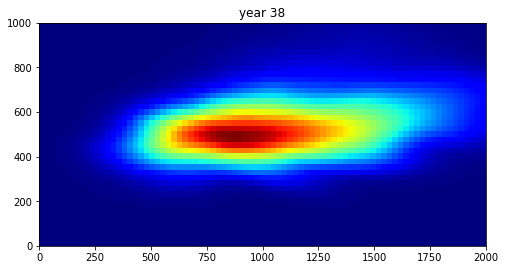

In [296]:
cvt = p03('binary_files', np.transpose(np.reshape(K[:,3], (81, 41))), welspd, spd)

dirname = 'binary_files'
model_ws = os.path.join(workdir, dirname)
fname = os.path.join(model_ws, 'MT3D001.UCN')
ucnobj = flopy.utils.UcnFile(fname)
times = ucnobj.get_times()

year = np.arange(2, 41)*365

def closest(lst, K): 
    lst = np.asarray(lst) 
    idx = (np.abs(lst - K)).argmin() 
    return lst[idx]

time = [closest(times, year[i]) for i in range(len(year))]
nx = 81
ny = 41
Lx = 2000
Ly = 1000

x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
X,Y = np.meshgrid(x, y)

fig, axs = plt.subplots()
#        axs.set_xlabel('x(m)')
#        axs.set_ylabel('y(m)')
axs.set_xlim(0,Lx)
axs.set_ylim(0,Ly)

for i in range(len(year)):
    c_map = ucnobj.get_data(totim=time[i])[0,]
    plt.imshow(c_map, cmap='jet',
          extent=[x.min(), x.max(), y.min(), y.max()],
          vmin=c_map.min(), vmax = c_map.max(),
          origin='lower')
    plt.title("year {}".format(i))
    plt.show()
    # Note that using time.sleep does *not* work here!
    sleep(0.1)
    clear_output(wait=True)

In [316]:
obs = [[obs[i][j]+1 for j in range(3)] for i in range(len(obs))]

In [317]:
obs

[[1, 32, 40],
 [1, 19, 47],
 [1, 21, 39],
 [1, 28, 67],
 [1, 25, 51],
 [1, 13, 22],
 [1, 20, 60],
 [1, 31, 23],
 [1, 34, 29],
 [1, 19, 56],
 [1, 23, 65],
 [1, 22, 29],
 [1, 35, 46],
 [1, 18, 35],
 [1, 6, 57],
 [1, 31, 50],
 [1, 9, 43],
 [1, 22, 51],
 [1, 12, 31],
 [1, 32, 31]]

In [306]:
times[inds[-2]]

14417.5